In [37]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : HandCrafted AntiSymmetric Bipolar Convolution


In [38]:
k = 20 # Top 10% highest l2-magnitude filters

In [39]:
F = 0

filters = np.zeros((3,3,1,1))

t = np.zeros((3,3))
t[0, 0] = 1.
filters = np.reshape(fft.idctn(t, norm='ortho'), (3,3,1,1)) 
#filters /= np.sum(np.abs(filters))

#filters[:,:,0,0] =  (1/9)*np.array([[1,1,1], [1,1,1], [1,1,1]]) + (1/6)*np.array([[1,1,1], [0,0,0], [-1,-1,-1]]) 


theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)

a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])
mag = reduce_euclidean_norm(filters, axis=[0,1])


x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()
y =( a_mag[:,F]*np.sin((theta[:,F]))).numpy()
z =(s_mag[:,F]*np.sign(np.mean(s, axis=(0,1)))[:,F]).numpy()
plt.rcParams.update({'figure.dpi': '100'})




(3, 3, 1, 1)
(1, 3, 3, 1) (1, 3, 3, 1) (1, 3, 3, 1)


In [40]:
3//2

1

In [41]:
#var = 2/(128*9)

img = np.zeros((115,115)) # cv2.imread('input4.png', 0)/255. 
mid = img.shape[0]//2
img[mid, mid] = 1.
#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)

(115, 115)


In [42]:
np.var(img), 1/(128*9)


(7.560864919722271e-05, 0.0008680555555555555)

(3, 3, 1, 1)
0
(1, 115, 115, 1)
VALS 1.0
tf.Tensor(0.0, shape=(), dtype=float32) 0.0
(1, 115, 115, 1)
1
(1, 115, 115, 1)
VALS 1.0
tf.Tensor(0.0, shape=(), dtype=float32) 0.8164966
(1, 115, 115, 1)
2
(1, 115, 115, 1)
VALS 1.0000001
tf.Tensor(0.0, shape=(), dtype=float32) 1.1547005
(1, 115, 115, 1)
3
(1, 115, 115, 1)
VALS 1.0000001
tf.Tensor(0.0, shape=(), dtype=float32) 1.4142135
(1, 115, 115, 1)
4
(1, 115, 115, 1)
VALS 0.99999994
tf.Tensor(0.0, shape=(), dtype=float32) 1.6329931
(1, 115, 115, 1)
5
(1, 115, 115, 1)
VALS 1.0
tf.Tensor(0.0, shape=(), dtype=float32) 1.8257419
(1, 115, 115, 1)
6
(1, 115, 115, 1)
VALS 1.0
tf.Tensor(5.9604645e-08, shape=(), dtype=float32) 2.0
(1, 115, 115, 1)
7
(1, 115, 115, 1)
VALS 1.0
tf.Tensor(-3.7718564e-08, shape=(), dtype=float32) 2.1602468
(1, 115, 115, 1)
8
(1, 115, 115, 1)
VALS 0.99999994
tf.Tensor(1.1175871e-08, shape=(), dtype=float32) 2.3094008
(1, 115, 115, 1)
9
(1, 115, 115, 1)
VALS 1.0
tf.Tensor(-1.3038516e-08, shape=(), dtype=float32) 2.449489

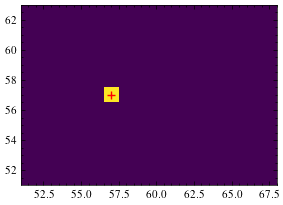

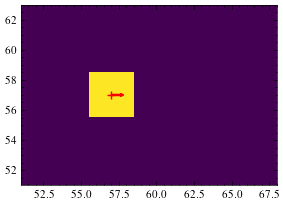

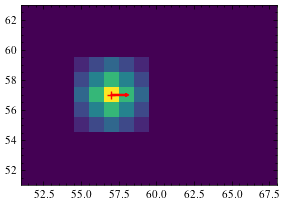

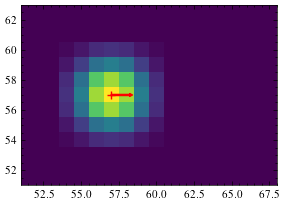

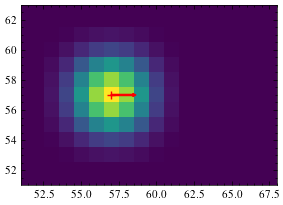

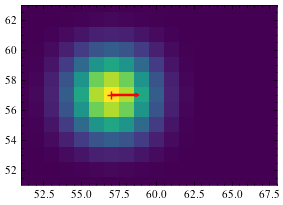

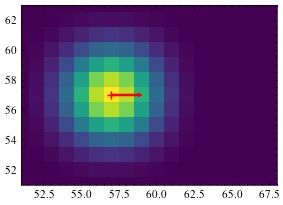

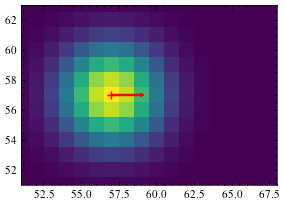

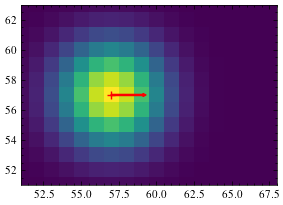

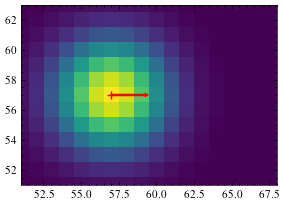

In [43]:
import matplotlib.patches as mpatches

w =tf.cast(filters, dtype=tf.float32)# tf.expand_dims(filters, -1), dtype=tf.float32)
w = tf.transpose(w, perm=(1,0,2,3))
print(w.shape)

x = img


directory = f"figures/prop_unipolar_0"
if not os.path.exists(directory):
	os.makedirs(directory)
x = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 
for i in range(10):
	print(i)
	#if i in [0, 19, 39, 59, 79]:
	fig, ax = plt.subplots()
	print(x.shape)
	x = x/np.std(x)
	vals = x[0, x.shape[1]//2, :, :]
	vals = vals/np.sum(vals)

	print("VALS", np.sum(vals))
	pos = np.expand_dims(np.linspace(-(x.shape[1]//2), x.shape[1]//2, x.shape[1]),-1)
	mean = tf.reduce_sum(pos*vals)
	var = tf.reduce_sum(((pos-mean)**2) * vals)
	std = np.sqrt(var)
	print(mean, np.sqrt(var))
	
	#x = tf.repeat(x , repeats = filters.shape[-2], axis=-1)
	print(x.shape)

	im = ax.imshow(np.sum(x[0,:,:,:], axis=-1))
	ax.plot(mid, mid, marker = '+', color='red')

	#ax.plot(112+mean, 112, marker = ".", color='black')
	arr =  mpatches.FancyArrowPatch((mid, mid), (mid+std, mid),
							mutation_scale=4, shrinkA=0, shrinkB=0,zorder=10, color="red")
	ax.add_patch(arr)
	
	#ax.annotate(r'$\sigma=$'+f"{std:.2f}", (.5, 6), xycoords=arr, ha='center', va='bottom',color='white')
	#ax.arrow(, 112, dx=, dy= 0, color='black')

	ax.set(xlim=( (mid-(5)-1), (mid+(10)+1)), ylim=((mid-(5)-1), (mid+(5)+1)))
	#ax.set_xticks(np.linspace(-round(std)-1, round(std)+1, int(0.5*(std)+3)))
	#fig.colorbar(im, orientation='vertical')
	fig.savefig(directory + f'/{i}.pdf', dpi=150,  transparent=True, bbox_inches='tight')

	x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							padding='SAME') )

(0.0, 224.0)

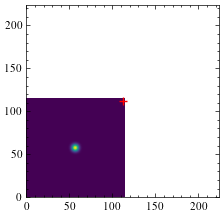

In [44]:
x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
						padding='SAME') )
	
im = plt.imshow(np.sum(x[0,:,:,:], axis=-1))
plt.plot(112, 112, marker = '+', color='red')
plt.xlim([0, 224])#, ylim=(0, 224))
plt.ylim([0, 224])#, ylim=(0, 224))

#, ylim=(0, 224))

In [45]:
pos[:, x.shape[1]//2, : , :]

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

In [ ]:
pos

In [ ]:
pos[x.shape[1]//2]